In [50]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


In [51]:
path = 'data/'
files = os.listdir(path)
# Solo se retienen archivos nc
dict_files = {
    'date':list(),
    'link':list()
}

for file in files:
    if '.nc' in file:
        # generacion link
        link = os.path.join(
            path,
            file
        )
        #Formateo fecha
        year = file.split('_')[2]
        month = file.split('_')[3].split('.')[0]
        date = pd.to_datetime(year + '/' + month)
        # Almacenamiento
        dict_files['date'].append(date)
        dict_files['link'].append(link)
# Creacion del dataframe
df_files = pd.DataFrame(dict_files)
df_files.set_index(
    'date',
    drop=True,
    inplace=True
)
df_files = df_files.sort_index()

In [52]:
def get_all_data():
    combined = xr.open_dataset(df_files['link'][0])
    for i,link in enumerate(df_files['link'].to_numpy()):
        # print(f'processing {link}')
        temporal = xr.open_dataset(link)
        combined = xr.concat([combined,temporal],dim = "valid_time")
    return combined.to_dataframe()

def get_data_by_coordenates(lat,long):
    combined = xr.open_dataset(df_files['link'][0]).sel(
            latitude= lat,
            longitude = long,
            method = 'nearest'

    )
    for i,link in enumerate(df_files['link'][1:].to_numpy()):
        # print(f'processing {link}')
        temporal = xr.open_dataset(link).sel(
            latitude= lat,
            longitude = long,
            method = 'nearest'

        )
        combined = xr.concat([combined,temporal],dim = "valid_time")
    return combined.to_dataframe()

def get_data_by_coordenates_date(lat,long,start,end):
    # se entregan los datos de fecha con el formato "1990-01-30"

    df_filtered = df_files[(df_files.index>=start) & (df_files.index<end)]
    
    acum = xr.open_dataset(df_filtered['link'][0]).sel(
            latitude= lat,
            longitude = long,
            method = 'nearest'

    )
    for i,link in enumerate(df_filtered[(df_filtered.index>=start) & (df_filtered.index<end)]['link'][1:].to_numpy()):
        # print(f'processing {link}')
        temporal = xr.open_dataset(link).sel(
            latitude= lat,
            longitude = long,
            method = 'nearest'

        )
        acum = xr.concat([acum,temporal],dim = "valid_time")
    return acum.to_dataframe()


In [53]:

x_training = get_data_by_coordenates_date(0, -73.5,'2009','2010')
y_training = get_data_by_coordenates_date(0.5, -73.0,'2009','2010')


/tmp/ipykernel_48235/3433687123.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  acum = xr.open_dataset(df_filtered['link'][0]).sel(
/tmp/ipykernel_48235/3433687123.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  acum = xr.open_dataset(df_filtered['link'][0]).sel(


In [54]:
x_training = np.hypot(x_training['u10'],x_training['v10'])
y_training = np.hypot(y_training['u10'],y_training['v10'])

In [55]:
np.corrcoef(x_training,y_training)[0][1]

np.float64(0.8156052882767852)

In [56]:
x_training = x_training/max(x_training)
y_training = y_training/max(y_training)
x_training = pd.DataFrame((x_training).to_numpy())
y_training = pd.DataFrame((y_training).to_numpy())

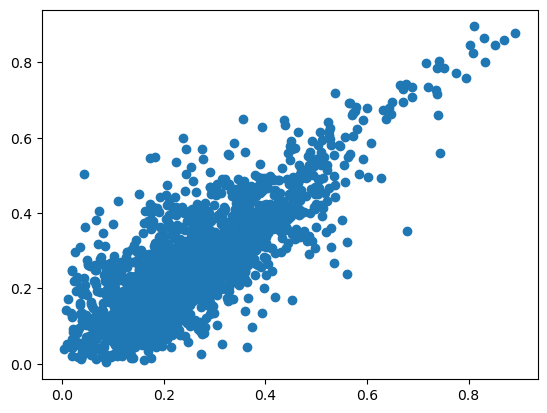

In [57]:

plt.scatter(x_training[0:2000],y_training[0:2000])

In [72]:
from sklearn.linear_model import Ridge, LinearRegression,LassoCV

modelRidge = Ridge()
modelRidge.fit(x_training,y_training)
print("Ridge score:",modelRidge.score(x_training,y_training))

modelLinear = LinearRegression()
modelLinear.fit(x_training,y_training)
print("Linear score:",modelLinear.score(x_training,y_training))

modelLasso = LassoCV(alphas = [0.0001, 0.001,0.01, 0.1, 1, 10], random_state=0).fit(x_training, y_training)
modelLasso.fit(x_training,y_training)
print("Lasso score:",modelLasso.score(x_training,y_training))

Ridge score: 0.6651754379272461
Linear score: 0.6652120351791382
Lasso score: 0.6651726961135864


/home/choclo/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:1714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/choclo/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:1714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


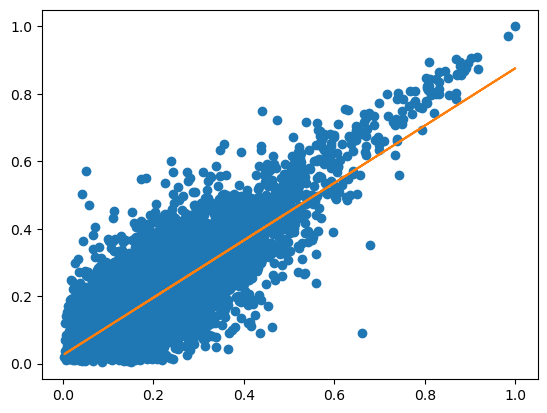

In [73]:
plt.scatter(x_training, y_training, label="Data Points")
plt.plot(x_training,modelLinear.predict(x_training),'C1')